In [10]:
import matplotlib.pyplot as plt
import jax.numpy as np
import tigercontrol
from tigercontrol.methods.control import ControlMethod
from jax import grad,jit
import jax
from tigercontrol.utils.random import set_key

In [19]:
def get_trajectory(problem, method, key = 0, T = 100):
    set_key(key)

    (problem_id, problem_params) = problem
    (method_id, method_params) = method
    
    problem = tigercontrol.problem(problem_id)
    x = problem.initialize(**problem_params)
    
    method_params['A'], method_params['B'] = problem.A, problem.B
    method_params['x'] = x
    
    method = tigercontrol.method(method_id)
    method.initialize(**method_params)
    
    trajectory = []
    norms = []
    avg_regret = []
    cur_avg = 0
    
    if(method.is_online):
        for i in range(T):
            u = method.plan(x)
            x = problem.step(u)
            trajectory.append(x) # get trajectory
            norms.append(np.linalg.norm(x))
            cur_avg = (i / (i + 1)) * cur_avg + (np.linalg.norm(x) + np.linalg.norm(u)) / (i + 1)
            avg_regret.append(cur_avg)
    else:
        u = method.plan()
        for i in range(T):
            x = problem.step(u[i])
            trajectory.append(x)
            norms.append(np.linalg.norm(x))
            cur_avg = (i / (i + 1)) * cur_avg + (np.linalg.norm(x) + np.linalg.norm(u[i])) / (i + 1)
            avg_regret.append(cur_avg)
            
    return trajectory, norms, avg_regret

In [20]:
T = 500

In [21]:
n = 1 # dimension of  the state x 
m = 1 # control dimension
noise_magnitude = 0.2
noise_distribution = 'normal'

problem_id = "LDS-v0"
problem_params = {'n': n, 'm' : m, 'noise_magnitude' : noise_magnitude, 'noise_distribution' : noise_distribution}

In [22]:
H, HH = 3, 30
GPC_params = {'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K' : np.zeros((m, n))}

In [23]:
GPC_results, GPC_norms, GPC_avg_results = get_trajectory((problem_id, problem_params), ('GPC', GPC_params), key = 0, T = T)

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


In [24]:
C = np.identity(n + m) # quadratic cost
LQR_params = {'C' : C, 'T' : T}

In [25]:
LQR_results, LQR_norms, LQR_avg_results = get_trajectory((problem_id, problem_params), ('LQR', LQR_params), key = 0, T = T)

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:119: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:211: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


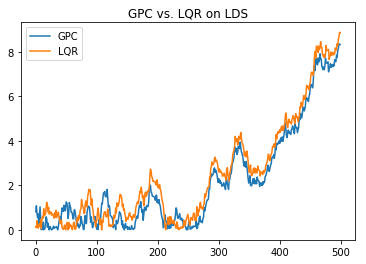

In [26]:
plt.plot(GPC_norms, label = "GPC")
plt.plot(LQR_norms, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();